# Analyse de sentiment sur les critiques d'IMDB

Le corpus d'origine peut être téléchargé ici : http://ai.stanford.edu/~amaas/data/sentiment/. Il contient plusieurs répertoires et autant de fichiers que de critiques de films.
Pour l'utiliser : placer le fichier (.tar.gz) téléchargé dans le répertoire du projet et le décompresser. Il faut ensuite le mettre en forme en utilisant le code fourni plus bas.

Le corpus déjà mis en forme en un seul fichier .csv est disponible ici : https://drive.google.com/file/d/1LnfB59FpNkmX3xVXAL3oc4YyeAIiXod5/view?usp=sharing

**Code source inspiré de** : https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

## Les import nécessaires

*NB : les modules doivent avoir auparavant été installés dans votre environnement Python. Cela peut se faire via la commande conda install si vous utilisez le gestionnaire conda/anaconda ou bien via pip. Dans le cadre de Google Colab, tous les modules sont déjà pré-installés, à l'exception de MulticoreTSNE.*


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import gensim

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud
import nltk

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Flatten
from keras.initializers import Constant

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score
from sklearn.metrics  import classification_report
from sklearn.metrics  import roc_curve
from sklearn.metrics  import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [3]:
import sys
sys.path.append('Multicore-TSNE')  # Remplacez '/chemin/vers/votre/dossier/Multicore-TSNE' par le chemin réel

from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
from sklearn.manifold import TSNE

## Lecture du fichier .csv (corpus de données déjà mis en forme)

Le corpus IMDB mis en forme en un seul fichier .csv (62 Mo) est disponible ici :
- https://drive.google.com/file/d/1LnfB59FpNkmX3xVXAL3oc4YyeAIiXod5/view?usp=sharing
- https://www.icloud.com/iclouddrive/0_WX0yxTHJXU4rd6GEeSTutWQ#movie_data

Vous devez le dupliquer sur votre Google drive personnel et le positionner dans votre "repertoire_depart" indiqué au début du carnet.

In [5]:
nomCSV = "data/movie_data.csv"
df = pd.read_csv(nomCSV, encoding='utf-8')
df.head()

review  polarity
0  Based on an actual story, John Boorman shows t...         1
1  This is a gem. As a Film Four production - the...         1
2  I really like this show. It has drama, romance...         1
3  This is the best 3-D experience Disney has at ...         1
4  Of the Korean movies I've seen, only three had...         1

## Exploration du corpus et premiers éléments statistiques

In [6]:
print("Nombre total de critiques : ", len(df))
print("Nombre de critiques positives : ", len(df[df['polarity']==1]))
print("Nombre de critiques négatives : ", (df['polarity']==0).sum())
print("polarité : ", df['polarity'][1], " -- ", df['review'][1])
print("polarité : ", df['polarity'][2], " -- ", df['review'][2])

Nombre total de critiques :  50000
Nombre de critiques positives :  25000
Nombre de critiques négatives :  25000
polarité :  1  --  This is a gem. As a Film Four production - the anticipated quality was indeed delivered. Shot with great style that reminded me some Errol Morris films, well arranged and simply gripping. It's long yet horrifying to the point it's excruciating. We know something bad happened (one can guess by the lack of participation of a person in the interviews) but we are compelled to see it, a bit like a car accident in slow motion. The story spans most conceivable aspects and unlike some documentaries did not try and refrain from showing the grimmer sides of the stories, as also dealing with the guilt of the people Don left behind him, wondering why they didn't stop him in time. It took me a few hours to get out of the melancholy that gripped me after seeing this very-well made documentary.
polarité :  1  --  I really like this show. It has drama, romance, and comedy

### Analyse globale du lexique avec le module NLTK

In [7]:
reviews = df.review.str.cat(sep=' ')

In [8]:
print(reviews[:1000])
print(len(reviews))

Based on an actual story, John Boorman shows the struggle of an American doctor, whose husband and son were murdered and she was continually plagued with her loss. A holiday to Burma with her sister seemed like a good idea to get away from it all, but when her passport was stolen in Rangoon, she could not leave the country with her sister, and was forced to stay back until she could get I.D. papers from the American embassy. To fill in a day before she could fly out, she took a trip into the countryside with a tour guide. "I tried finding something in those stone statues, but nothing stirred in me. I was stone myself." <br /><br />Suddenly all hell broke loose and she was caught in a political revolt. Just when it looked like she had escaped and safely boarded a train, she saw her tour guide get beaten and shot. In a split second she decided to jump from the moving train and try to rescue him, with no thought of herself. Continually her life was in danger. <br /><br />Here is a woman w

In [9]:
tokens = word_tokenize(reviews[:10000000])

In [12]:
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
hapax = frequency_dist.hapaxes()

In [13]:
print("Nombre total de mots ", len(tokens))
print("Nombre de mots différents : ", len(vocabulary))
print("Taille totale des critiques en nombre de caractères :", len(reviews))
print(len(hapax)," mots qui n'apparaissent qu'une fois.")
print("Parmi les mots qui n'apparaissent qu'une seule fois :")
for _ in range(30):
    print(hapax[_], " ", end='')
print('\nLe mot le plus fréquent, ', frequency_dist.max()," , apparait ", frequency_dist[frequency_dist.max()], " fois")

Nombre total de mots  2116535
Nombre de mots différents :  68585
Taille totale des critiques en nombre de caractères : 65521550
33705  mots qui n'apparaissent qu'une fois.
Parmi les mots qui n'apparaissent qu'une seule fois :
I.D  Continually  very-well  up-to-date  themeparks  acid-trip  leagues  Disney-MGM  EO  artistically-inclined  conscience-less  crack-pot  hehehe  monsieur  non-lonely  surroundings.  objects.  upsetting.  finger-sewing  dreamily  boondoggling  Bathian  moneygrubbing  smarmy.  Olivier/Garson  cold-fish  highlife  Marchionesse  Udolpho  frazzled.  
Le mot le plus fréquent,  the  , apparait  89065  fois


## Visualisation de la distribution du lexique

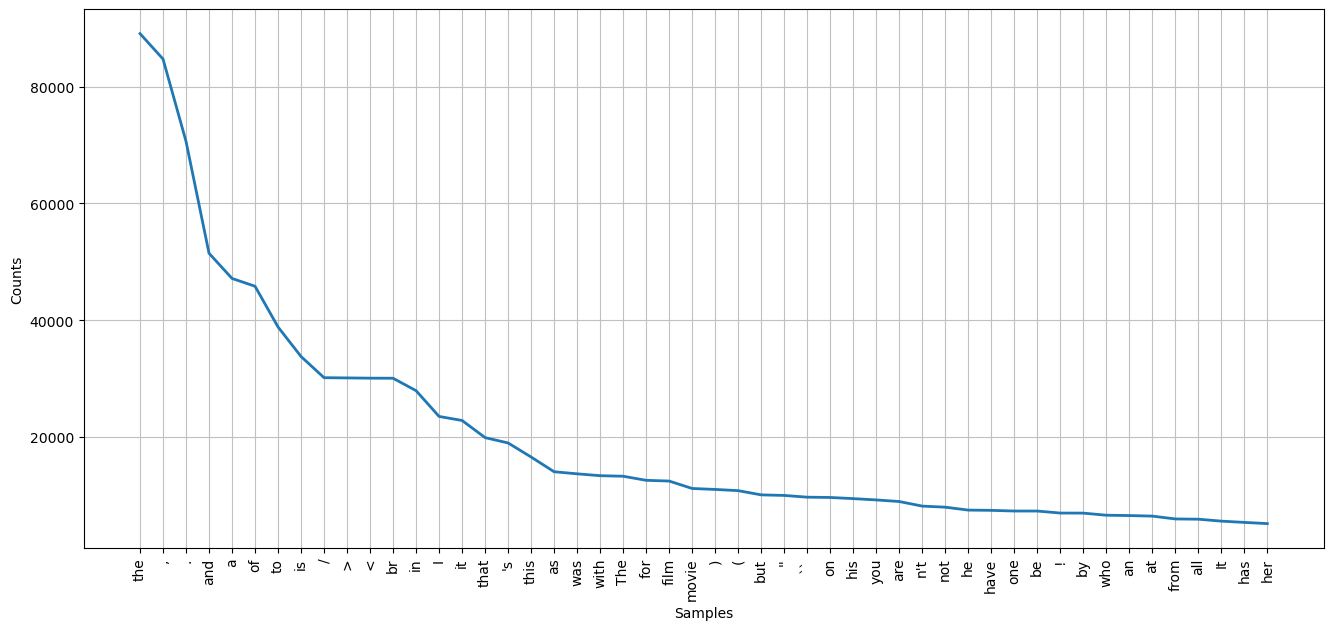

<Axes: xlabel='Samples', ylabel='Counts'>

In [14]:
plt.figure(figsize=(16,7))
frequency_dist.plot(50)

### Elimination des mots outils et des mots d'un seul caractère

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [w.lower() for w in tokens if not w.lower() in stop_words and len(w)>2]
vocabulary = set(tokens)
print("Taille du vocabulaire : ", len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
#sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

Taille du vocabulaire :  57995


In [16]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Visualisation du lexique après suppression des mots outils

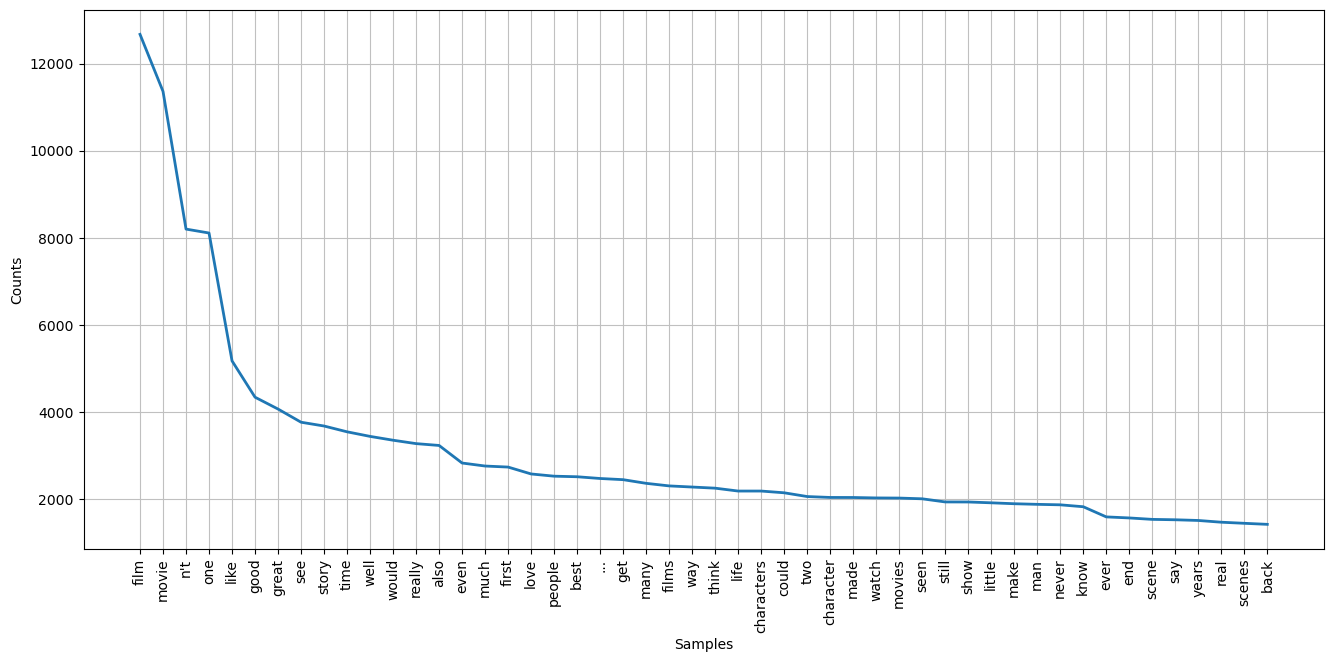

<Axes: xlabel='Samples', ylabel='Counts'>

In [17]:
plt.figure(figsize=(16,7))
frequency_dist.plot(50)

## Création de nuages de mots

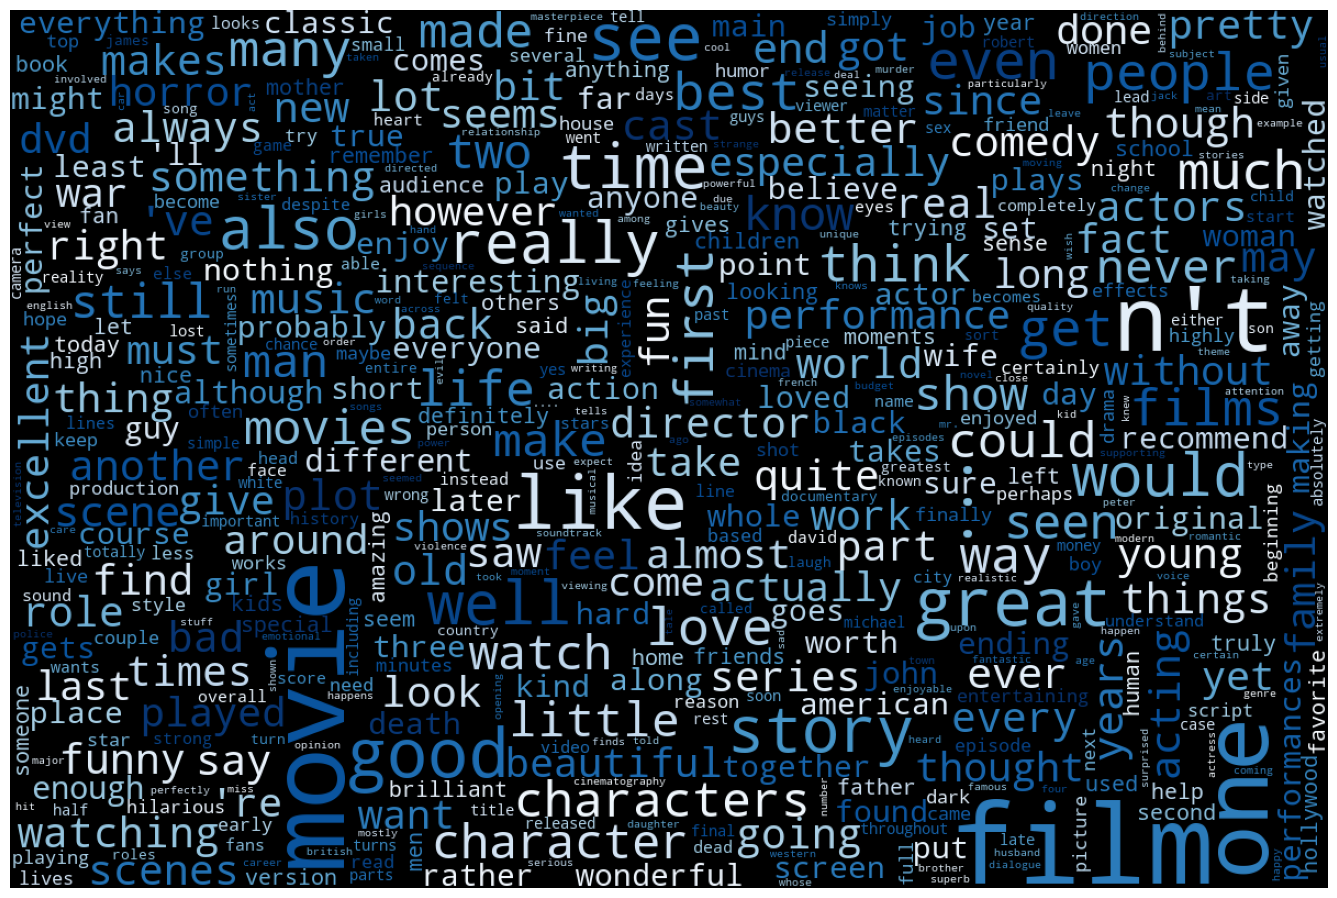

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Blues',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Différenciation entre les critiques positives et les négatives

#### Les critiques positives

In [19]:
reviewsPositives = df.review[df.polarity==1].str.cat(sep=' ')
tokensPos = word_tokenize(reviewsPositives)
tokensPos = [w.lower() for w in tokensPos if not w.lower() in stop_words and len(w)>2]
vocabPos = set(tokensPos)
frequency_dist_Pos = nltk.FreqDist(tokensPos)
#sorted(frequency_dist_Pos,key=frequency_dist_Pos.__getitem__, reverse=True)[0:50]

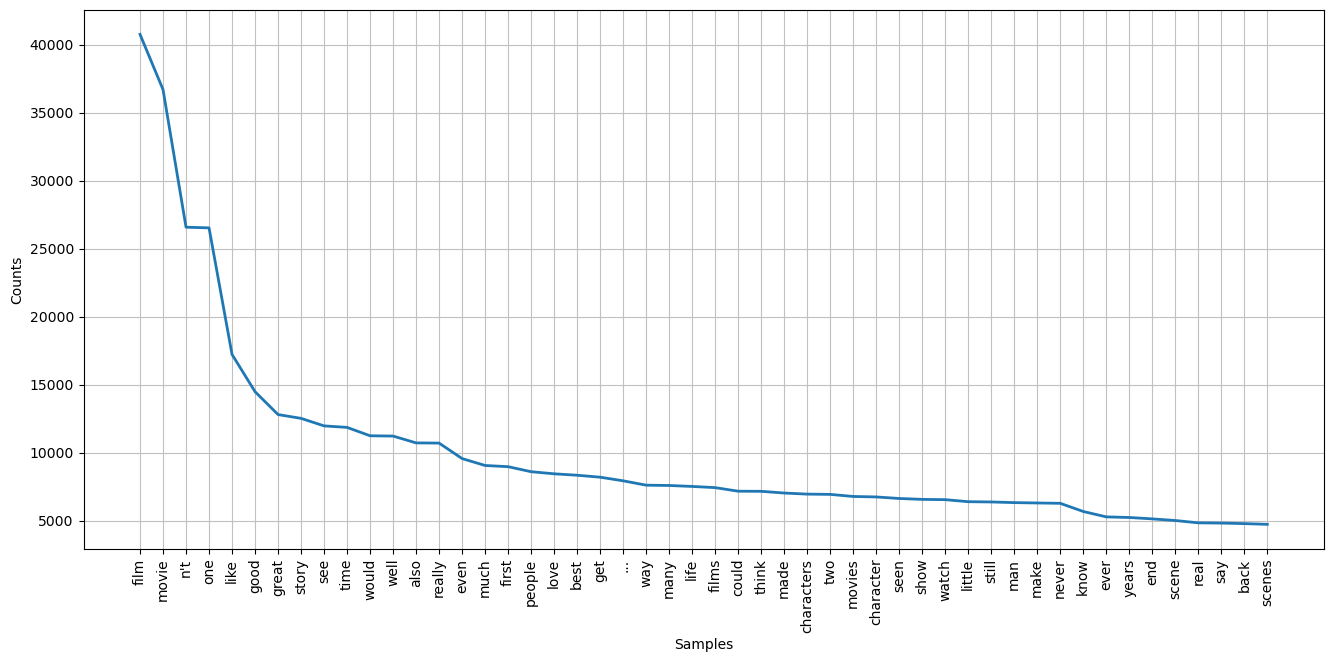

<Axes: xlabel='Samples', ylabel='Counts'>

In [20]:
plt.figure(figsize=(16,7))
frequency_dist_Pos.plot(50)

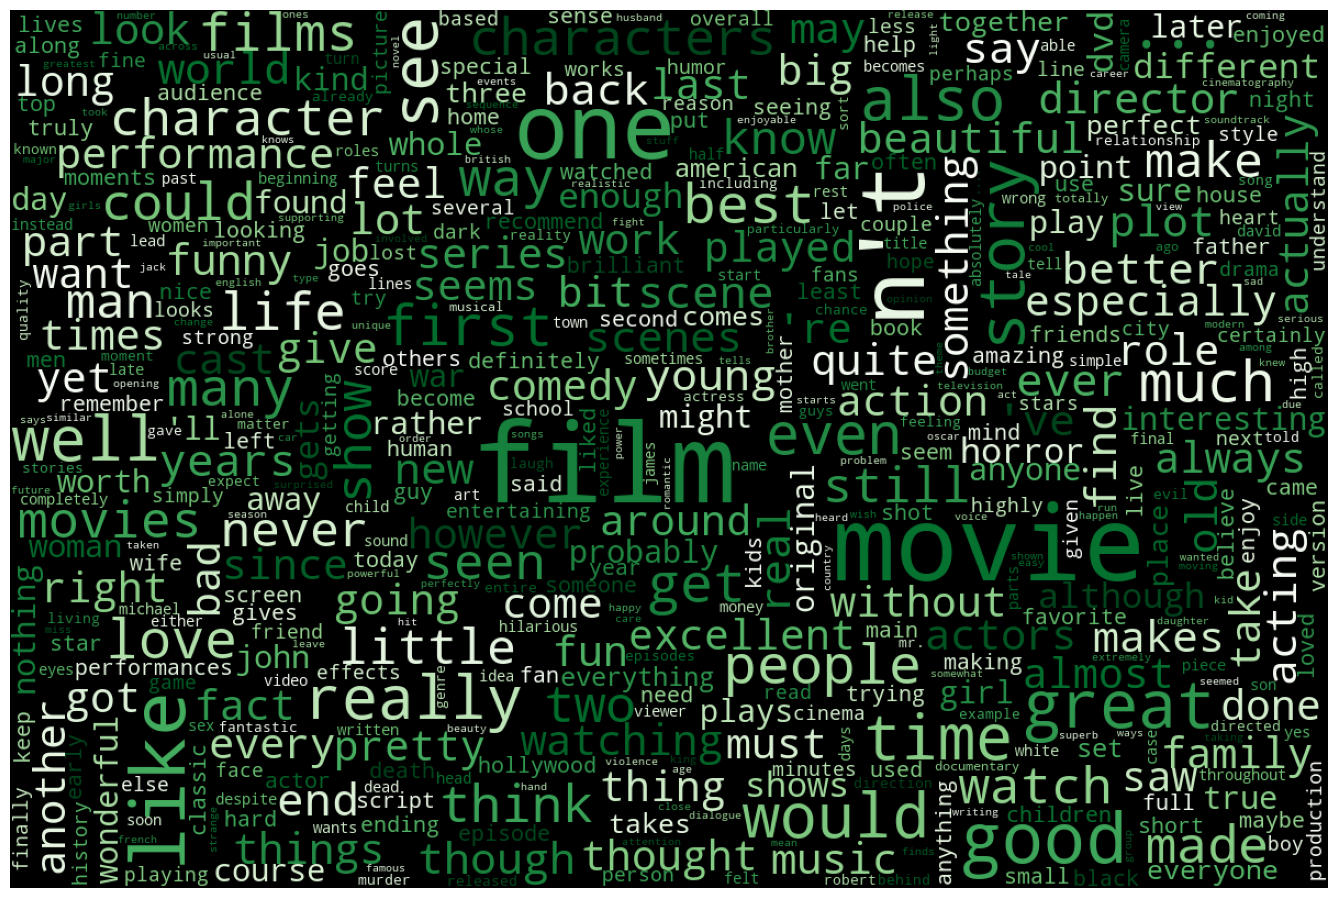

In [21]:
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Greens',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist_Pos)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Les critiques négatives

In [22]:
reviewsNegatives = df.review[df.polarity==0].str.cat(sep=' ')
tokensNeg = word_tokenize(reviewsNegatives)
tokensNeg = [w.lower() for w in tokensNeg if not w.lower() in stop_words and len(w)>2]
vocabNeg = set(tokensNeg)
frequency_dist_Neg = nltk.FreqDist(tokensNeg)
#sorted(frequency_dist_Neg,key=frequency_dist_Neg.__getitem__, reverse=True)[0:50]

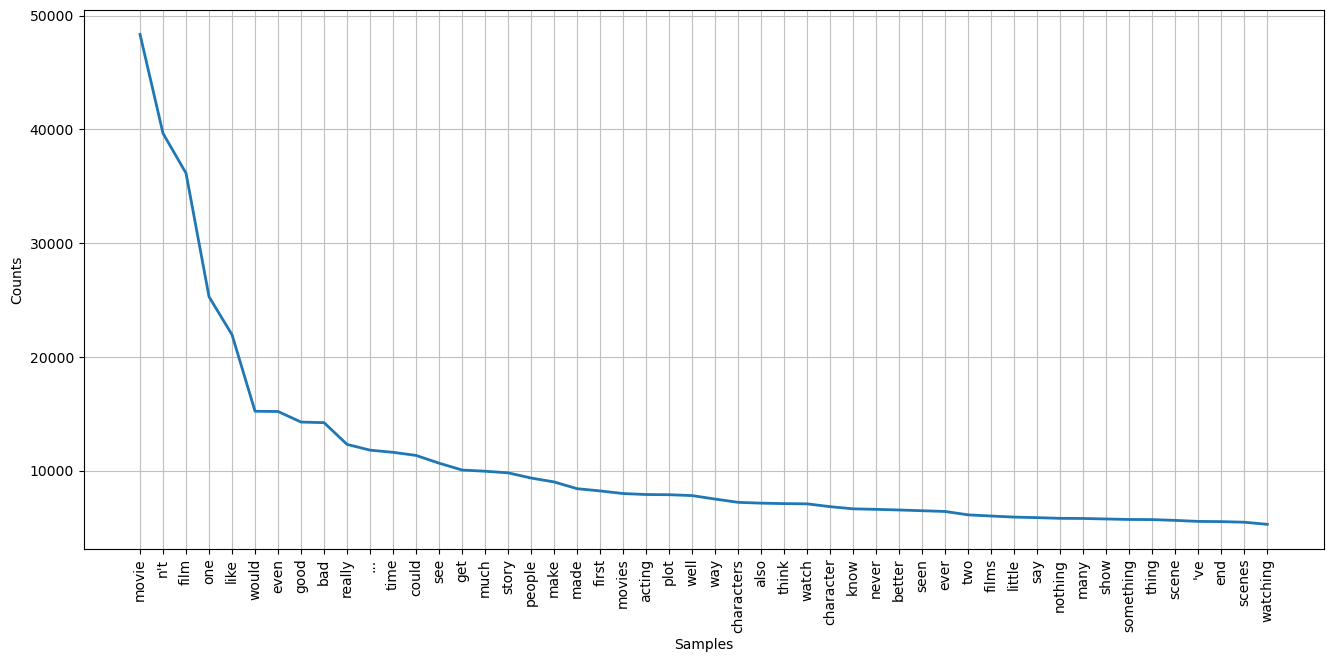

<Axes: xlabel='Samples', ylabel='Counts'>

In [23]:
plt.figure(figsize=(16,7))
frequency_dist_Neg.plot(50)

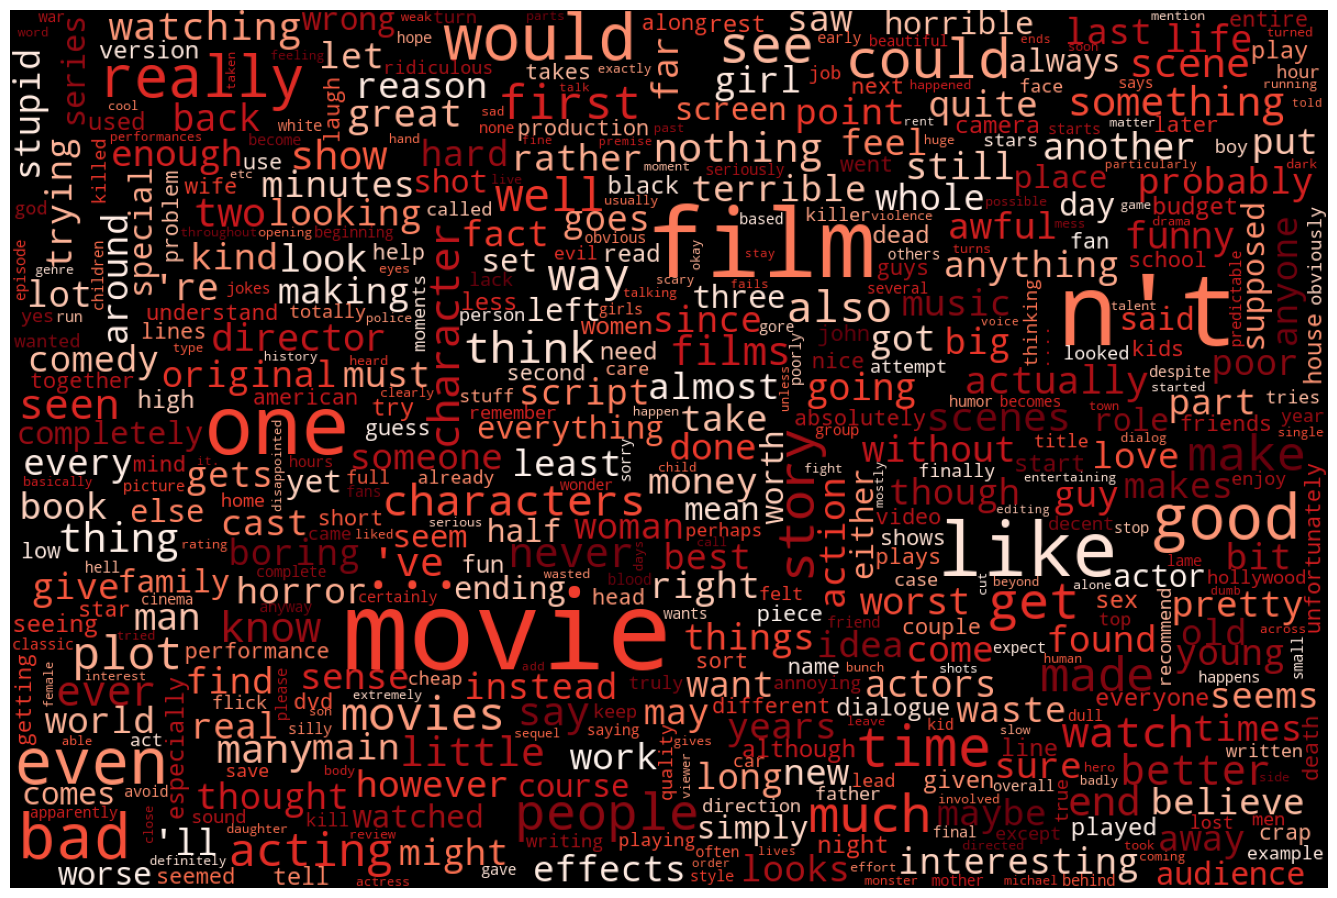

In [24]:
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Reds',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist_Neg)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Une première méthode de classification en polarité positive ou négative
## Utilisation d'un classifieur bayésien

### Subdivision du corpus en 2 parties : l'une pour l'entraînement, l'autre pour le test

In [25]:
X_train = df.loc[:24999, 'review'].to_numpy() #tableau des exemples de critiques pour l'entraînement --> X_train = le texte des exemples (l'entrée)
y_train = df.loc[:24999, 'polarity'].to_numpy() #pour chaque exemple de critique : sa classe 0 ou 1 --> y_train = sortie attendue
X_test = df.loc[25000:, 'review'].to_numpy() #les données de test = le texte des critiques que l'on veut tester
y_test = df.loc[25000:, 'polarity'].to_numpy() #les vraies classes attendues pour les données de test = ce que l'on veut obtenir

Vectorisation et estimation des poids tf.idf de chaque mot (nombre d'occurrences x log de l'inverse du nombre de critiques contenant le mot).
les valeurs idf sont apprises sur le corpus d'entraînement, les mots outils sont conservés, les 10 000 mots les plus fréquents sont conservés seulement.

Voir https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer
pour les paramètres possibles.

In [26]:
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [27]:
clf = MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)

In [28]:
print(X_test[1], "\nprédit :", predicted[1], "polarité vraie ", y_test[1], "\n Vecteur TF.IDF : ", test_vectors[1])

Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The movie is nearly a cross-pollination of "Rosemary's Baby" and "The Exorcist"--but what a combination! Based on the best-seller by Jeffrey Konvitz, "The Sentinel" is entertainingly spooky, full of shocks brought off well by director Michael Winner, who mounts a thoughtfully downbeat en

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Global Accuracy : 0.8454
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



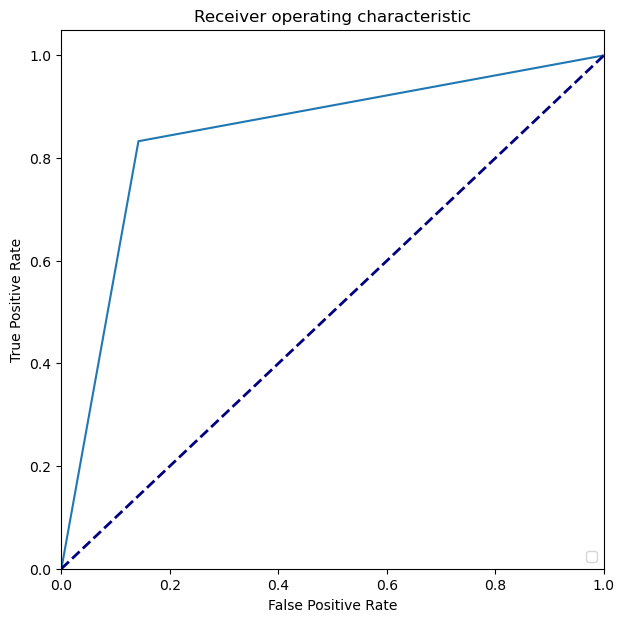

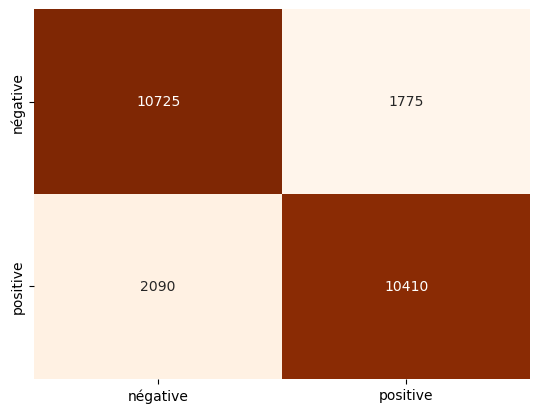

In [29]:
print("Global Accuracy :", accuracy_score(y_test,predicted)) #y_test = les sorties souhaitées ; predicted = les sorties obtenues
print(classification_report(y_test, predicted))

#Courbe ROC (voir https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
fp, tp, _ = roc_curve(y_test, predicted)
plt.figure(figsize=(7,7))
plt.plot(fp, tp, 2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Matrice de confusion
conf_mat = confusion_matrix(y_test, predicted)

columns = ['négative', 'positive']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
ax = seaborn.heatmap(df_cm, cmap='Oranges', annot=True, fmt="d", cbar=False)
                                                          

# Classification par réseau de neurones et plongements lexicaux (word embeddings)

### Pré-traitements (tokenisation, mise en minuscules, élimination des mots outils et des mots d'un seul caractère)


In [30]:
review_lines = list()

for line in df['review']:
    tokens = word_tokenize(line) #sépare les mots
    stop_words = set(stopwords.words('english')) #les mots outils
    tokens = [w.lower() for w in tokens if w.isalpha() and len(w)>1 and not w.lower() in stop_words] #filtre les mots outils et mets mots minuscules
    review_lines.append(tokens)

### Apprentissage des plongements avec une approche Word2Vec
La méthode d'apprentissage est celle de GenSim.
voir : https://radimrehurek.com/gensim/models/word2vec.html



#### Apprentissage du modèle Word2Vec
Paramètres à régler : nombre de dimensions, taille de la fenêtre, nombre de coeurs du CPU à utiliser, nombre minimal d'occurrences)

In [31]:
DIMENSION_EMBEDDINGS = 200
NB_OCCURRENCES_MIN = 10
TAILLE_FENETRE = 5

In [32]:
model = gensim.models.Word2Vec(sentences=review_lines, vector_size=DIMENSION_EMBEDDINGS, window=TAILLE_FENETRE, workers=3, min_count=NB_OCCURRENCES_MIN)
motsComplet = list(model.wv.key_to_index)

In [33]:
print ("nombre de mots retenus : ", len(motsComplet))

nombre de mots retenus :  26990


In [34]:
print(review_lines[1])

['gem', 'film', 'four', 'production', 'anticipated', 'quality', 'indeed', 'delivered', 'shot', 'great', 'style', 'reminded', 'errol', 'morris', 'films', 'well', 'arranged', 'simply', 'gripping', 'long', 'yet', 'horrifying', 'point', 'excruciating', 'know', 'something', 'bad', 'happened', 'one', 'guess', 'lack', 'participation', 'person', 'interviews', 'compelled', 'see', 'bit', 'like', 'car', 'accident', 'slow', 'motion', 'story', 'spans', 'conceivable', 'aspects', 'unlike', 'documentaries', 'try', 'refrain', 'showing', 'grimmer', 'sides', 'stories', 'also', 'dealing', 'guilt', 'people', 'left', 'behind', 'wondering', 'stop', 'time', 'took', 'hours', 'get', 'melancholy', 'gripped', 'seeing', 'made', 'documentary']


In [35]:
print(model.wv['movie'])

[-6.61652982e-01  1.11743248e+00  4.42276120e-01  8.92014056e-02
 -4.44813520e-01  2.38978773e-01  1.16116154e+00  1.13286916e-02
  7.70025194e-01  7.43351579e-01 -6.31148160e-01 -2.70601809e-01
 -4.83144939e-01  1.20724356e+00  2.13971108e-01  4.56226945e-01
 -1.67196020e-01 -4.23738837e-01 -1.88873243e+00  2.10277975e-01
 -3.49823684e-01  2.43104652e-01  1.21445751e+00 -1.07066464e+00
  3.17355514e-01 -1.31603444e+00  2.97979116e-01  1.19162440e-01
 -6.53054640e-02  3.17155123e-01  4.30967584e-02  6.47566378e-01
 -1.81304082e-01 -1.71416295e+00 -1.29587185e+00 -2.57336259e-01
  4.25925732e-01 -1.19587861e-01 -2.72248417e-01 -6.58093750e-01
 -5.96736312e-01  1.07200921e+00 -1.85854688e-01  9.13125515e-01
 -8.14707801e-02  7.64704823e-01 -1.36201093e-02  1.35891557e+00
  1.37916178e-01  5.22988915e-01 -6.19530439e-01  6.00430906e-01
  4.45603400e-01  4.93525535e-01 -2.34756336e-01  1.17434487e-01
  3.32104921e-01 -1.51434040e+00  2.49766737e-01  1.14575297e-01
  7.90647268e-01 -1.15558

#### Enregistrement du modèle appris
(ici format réduit : gain de place mais ne permet pas de continuer l'entraînement avec de nouveaux textes ajoutés -- pour enregistrer un modèle complet qui permet l'ajout, utiliser model.save à la place)

In [36]:
repertoire_depart = 'C:/Users/nscie/Desktop/Master_2/Recherches_Recommandation/TP_Fouille_de_texte'
nomEmbeddings = repertoire_depart+'/imdb_embeddings_word2vec_'+str(DIMENSION_EMBEDDINGS)+'_'+str(TAILLE_FENETRE)+'_'+str(NB_OCCURRENCES_MIN)

In [37]:
model.wv.save_word2vec_format(nomEmbeddings, binary=False)

### Exploration de l'espace de représentation

#### Recherche de mots similaires à un mot donné

In [38]:
print("Taille du vocabulaire : ", len(motsComplet))
print("Les mots les plus proches de horrible sont :")
print(model.wv.most_similar('horrible'))
print("Les mots les plus proches de superb sont :")
print(model.wv.most_similar('superb'))

Taille du vocabulaire :  26990
Les mots les plus proches de horrible sont :
[('terrible', 0.9078704714775085), ('awful', 0.8167764544487), ('horrendous', 0.7728543877601624), ('atrocious', 0.7387558221817017), ('pathetic', 0.7249021530151367), ('sucks', 0.7164950370788574), ('dreadful', 0.71199631690979), ('horrid', 0.6952210068702698), ('lousy', 0.6915776133537292), ('laughable', 0.6693417429924011)]
Les mots les plus proches de superb sont :
[('outstanding', 0.8611384034156799), ('excellent', 0.8461216688156128), ('phenomenal', 0.8395992517471313), ('exceptional', 0.8361909985542297), ('terrific', 0.8030524253845215), ('fantastic', 0.7919360995292664), ('marvelous', 0.7876498103141785), ('fabulous', 0.7754234075546265), ('splendid', 0.7643823623657227), ('impeccable', 0.7626556158065796)]


#### Exploration graphique globale

##### A l'aide d'une ACP
La méthode utilisée permet de visualiser l'ensemble des mots du vocabulaire retenu ou bien des mots spécifiques.

In [39]:
# d'après https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(motsComplet, sample)
        else:
            words = [ word for word in motsComplet ]

    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(18,18))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


#display_pca_scatterplot(model, ['superb', 'good', 'terrible', 'awful', 'pathetic', 'outstanding', 'terrific', 'bad'])
display_pca_scatterplot(model, sample=600)

##### A l'aide de l'approche t-NSE
voir https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
pour multi-coeurs : https://github.com/DmitryUlyanov/Multicore-TSNE

*! pour être utilisé, le code ci-dessus nécessite d'avoir exécuté au préalable la 1ère commande de la section "Analyse globale du lexique avec le module NLTK" en début de carnet*

In [40]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    perplexity = 40

    # Append tokens
    tokens = []
    for word in model.wv.key_to_index:
        if frequency_dist[word]>2000:
            tokens.append(model.wv[word])
            labels.append(word)

    new_values = [] # Initialize new_values upfront

    # Ensure tokens list is long enough
    if len(tokens) < perplexity:
        print(f"Not enough tokens for perplexity of {perplexity}")
    else:
        tsne_model = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=2500, random_state=23, verbose=True, n_jobs=12)
        new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)

Not enough tokens for perplexity of 40


<Figure size 1600x1600 with 0 Axes>

### Apprentissage du modèle neuronal de classification en exploitant une projection des critiques sur l'espace de représentation

Les critiques des films doivent être vectorisées dans l'espace de représentation. Il s'agit donc de représenter ces phrases dans une matrice de vecteurs de mots.
Par ailleurs, les critiques doivent être tronquées pour être de longueur égale. Il faut ainsi définir un nombre de mots maximum : au-delà, les mots suivants seront ignorés.

#### Tokenization avec les fonctions de TensorFlow / Keras
voir : https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

In [41]:
tokenizer_obj = Tokenizer(oov_token='UNK', char_level=False)
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

In [42]:
print (len(tokenizer_obj.word_index), " mots différents ont été trouvés")

96855  mots différents ont été trouvés


In [43]:
maxlen = 128

In [44]:
review_pad = pad_sequences(sequences, maxlen)
polarites = df['polarity'].to_numpy()

#### Construction de la matrice des plongements des mots des critiques

##### Ouverture et lecture du modèle de plongements Word2Vec

In [45]:
embeddings_index = {}
print("Utilisation du modèle Word2Vec : ", nomEmbeddings)
with open(nomEmbeddings, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs
print("Nombre de mots différents dans le modèle : ", len(embeddings_index))
print("Dimensions de l'espace : ", len(coefs))

Utilisation du modèle Word2Vec :  C:/Users/nscie/Desktop/Master_2/Recherches_Recommandation/TP_Fouille_de_texte/imdb_embeddings_word2vec_200_5_10
Nombre de mots différents dans le modèle :  26991
Dimensions de l'espace :  200


##### Projection dans l'espace de représentation

In [46]:
nombremots = len(tokenizer_obj.word_index) + 1
#mise à zéro d'une matrice de nombremots lignes et de la taille des embeddings comme nombre de colonnes
embedding_matrix = np.zeros((nombremots, DIMENSION_EMBEDDINGS))

for word, i in tokenizer_obj.word_index.items():
    if i > nombremots:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
print(nombremots)

96856


### Définition de l'architecture du réseau neuronal

In [48]:
model = Sequential()
embedding_layer = Embedding(nombremots, DIMENSION_EMBEDDINGS,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)
model.add(embedding_layer)

#model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))

#forward_layer = LSTM(10, return_sequences=True)
#backward_layer = LSTM(10, activation='relu', return_sequences=True,
#                       go_backwards=True)
#model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
#                         input_shape=(5, 10)))

# si pas GRU / LSTM mais couches denses directement alors la matrice des plongements doit être "mise à plat" :
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# avec valeur par défaut du "learning rate" :
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##### Réglage des paramètres d'apprentissage : (voir https://keras.io/api/optimizers/)
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
##### Ou bien :
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9)
#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#pour un descriptif des loss functions : https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 200)          19371200  
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 32)                819232    
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20190705 (77.02 MB)
Trainable params: 819505 (3.13 MB)
Non-trainable params: 19371200 (73.90 MB)
_________________________________________________________________


#### Entraînement du modèle à partir des plongements

Séparation en deux corpus, l'un d'entraînement et l'autre de validation par sélection aléatoire.

In [49]:
VALIDATION_SPLIT = 0.3
# mélange aléatoire de l'ensemble des critiques :
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = polarites[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

# séparation entre données d'entraînement et données de test :
X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

print("Dimension X_train_pad ", X_train_pad.shape)
print("Dimension y_train ", y_train.shape)
print("Dimension X_test_pad ", X_test_pad.shape)
print("Dimension y_test ", y_test.shape)

Dimension X_train_pad  (35000, 128)
Dimension y_train  (35000,)
Dimension X_test_pad  (15000, 128)
Dimension y_test  (15000,)


Appel de la méthode entraînant le réseau et test au fur et à mesure des époques :

In [50]:
#selon la configuration de votre machine, des conflits entre bibliothèques peuvent survenir. 
#Si Python quitte brutalement la ligne suivante peut permettre de contourner le problème
#sinon la mettre en commentaires
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

history = model.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/5


274/274 [==============================] - 2s 6ms/step - loss: 0.4720 - accuracy: 0.7806 - val_loss: 0.4482 - val_accuracy: 0.7924
Epoch 2/5
274/274 [==============================] - 1s 5ms/step - loss: 0.3279 - accuracy: 0.8546 - val_loss: 0.4342 - val_accuracy: 0.8035
Epoch 3/5
274/274 [==============================] - 1s 5ms/step - loss: 0.2492 - accuracy: 0.8904 - val_loss: 0.4985 - val_accuracy: 0.7936
Epoch 4/5
274/274 [==============================] - 1s 5ms/step - loss: 0.1840 - accuracy: 0.9197 - val_loss: 0.5993 - val_accuracy: 0.7869
Epoch 5/5
274/274 [==============================] - 1s 5ms/step - loss: 0.1370 - accuracy: 0.9437 - val_loss: 0.7644 - val_accuracy: 0.7863


### Enregistrement du modèle

In [80]:
nomModele = repertoire_depart+'/modele/modeleACC80'

In [81]:
model.save(nomModele)

INFO:tensorflow:Assets written to: C:/Users/nscie/Desktop/Master_2/Recherches_Recommandation/TP_Fouille_de_texte/modele/modeleACC80\assets


INFO:tensorflow:Assets written to: C:/Users/nscie/Desktop/Master_2/Recherches_Recommandation/TP_Fouille_de_texte/modele/modeleACC80\assets


In [76]:
del model

### Lecture du modèle appris

In [82]:
#la ligne suivante peut provoquer une erreur provenant d'une incompatibilité entre tensorflow et le module h5py
#en version 3.x --> dans ce cas, installer la version 2.10.0 : conda install h5py==2.10.0
model = keras.models.load_model(nomModele)

## Analyse des résultats

In [51]:
_, train_acc = model.evaluate(X_train_pad, y_train, verbose=1)
_, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

469/469 [==============================] - 0s 957us/step - loss: 0.7644 - accuracy: 0.7863
Train: 0.971, Test: 0.786


### Visualisation de l'historique de l'apprentissage

voir : Display Deep Learning Model Training History in Keras
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

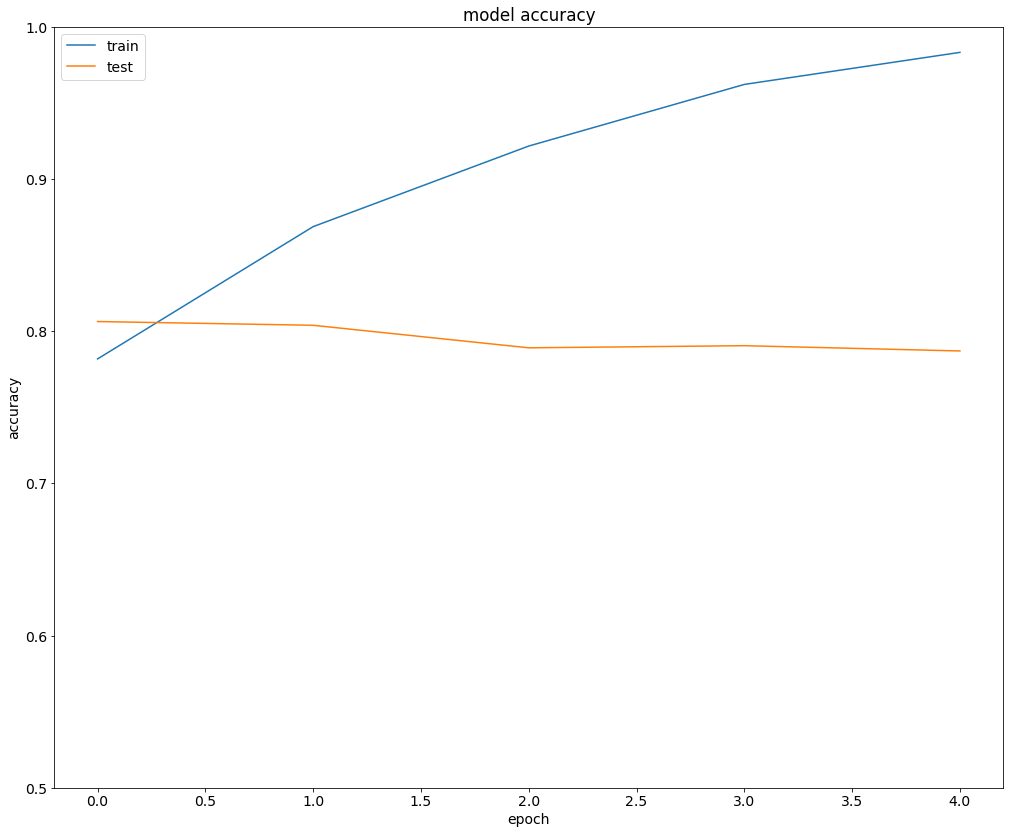

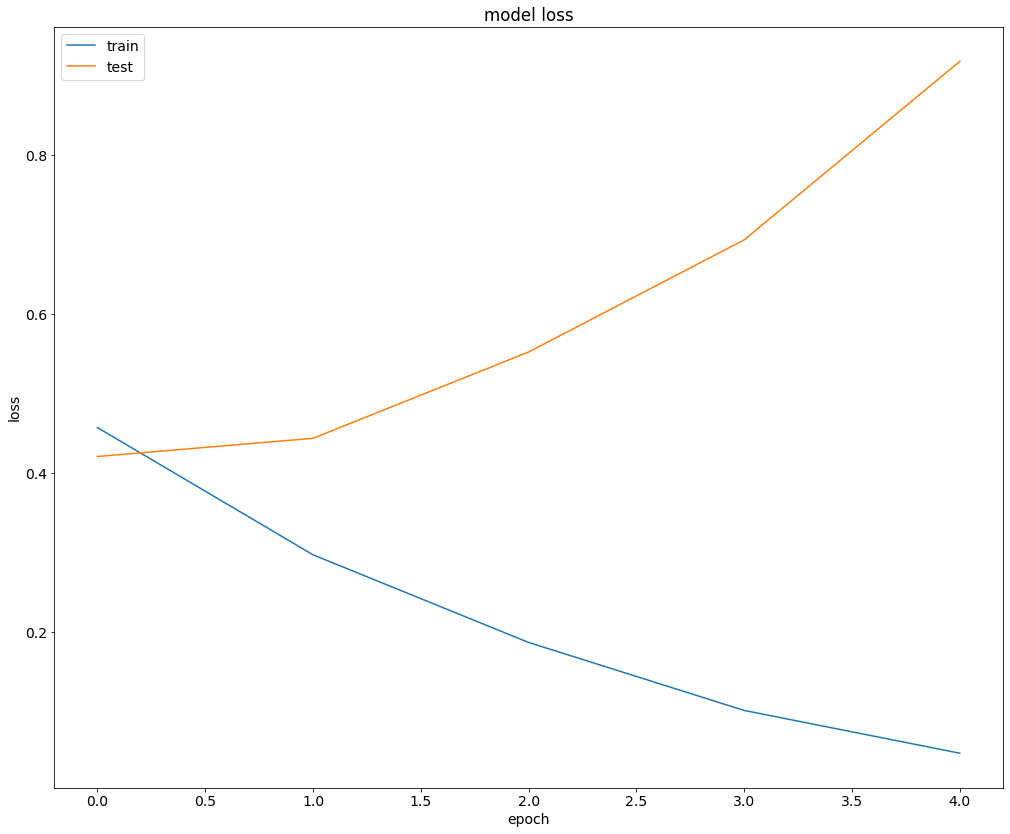

In [ ]:
plt.figure(figsize=(17,14))
plt.rc('font', size=14)
plt.ylim(0.5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(17,14))
plt.rc('font', size=14)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()